## BIOINF575-final: KEGG pathways overlap

Division: we divide the trasks and profread the work

1. setup

In [5]:
#Setup: deps, paths, helpers

import os, re, json, itertools as it
import pandas as pd
import requests

BASE_DIR = os.path.expanduser("~/bioinfo575_final")
OUTDIR = f"{BASE_DIR}/output" # processed data folder
RAWDIR = f"{BASE_DIR}/kegg_raw" # raw data folder
os.makedirs(OUTDIR, exist_ok=True) # ensure output dir exists for processed data
os.makedirs(RAWDIR, exist_ok=True) # ensure raw data dir exists for raw data

KEGG_DOC = "https://www.kegg.jp/kegg/rest/keggapi.html" #the KEGG API documentation
ENDPOINTS = {
    "pathways_hsa": "https://rest.kegg.jp/list/pathway/hsa", # gives us KEGG pathway IDs and regular pathway names
    "link_gene_pathway": "https://rest.kegg.jp/link/pathway/hsa", #tells us which KEGG gene IDs are in which pathways
    "genes_hsa": "https://rest.kegg.jp/list/hsa", #translates KEGG gene IDs to gene names/descriptions
}
UA_HEADERS = {"User-Agent": "curl/8.4.0", "Accept": "text/plain"}


#Preprocessing to confirm KEGG responses are TSV, remove blank lines, and save raw data

def fetch_tsv(url: str, raw_save_path: str, timeout: int = 60):
    r = requests.get(url, headers=UA_HEADERS, allow_redirects=True, timeout=timeout)
    r.raise_for_status()
    text = r.text
    with open(raw_save_path, "w", encoding="utf-8") as f:
        f.write(text)
    lines = [ln for ln in text.splitlines() if ln.strip()]
    if sum("\t" in ln for ln in lines) == 0:
        raise RuntimeError(f"Non-TSV response for {url}; saved to: {raw_save_path}")
    return lines


2. step1: Map/merge the information by PATHWAY_ID and GENE_ID

In [6]:
#Step 1: Map/Merge by PATHWAY_ID & GENE_ID

#Get the raw data from the KEGG REST API endpoints.
#Save the raw data of the files that tell us the pathways and genes that exist and which genes are assigned to each pathway. 
pathways_lines = fetch_tsv(ENDPOINTS["pathways_hsa"], f"{RAWDIR}/pathways_hsa.tsv")
links_lines    = fetch_tsv(ENDPOINTS["link_gene_pathway"], f"{RAWDIR}/link_pathway_hsa.tsv")
genes_lines    = fetch_tsv(ENDPOINTS["genes_hsa"], f"{RAWDIR}/genes_hsa.tsv")


#Create a dictionary mapping PATHWAY_ID (pid) to PATHWAY_NAME (pname)
pid2name = {}
for ln in pathways_lines:
    if "\t" not in ln:
        continue
    pid, pname = ln.split("\t", 1)
    pid = pid.replace("path:", "").strip()
    pid2name[pid] = pname.strip()

#Create a dictionary mapping GENE_ID (gid) to GENE_SYMBOL (sym)
gid2sym = {}
for ln in genes_lines:
    if "\t" not in ln:
        continue
    parts = ln.split("\t")
    gid = parts[0].strip()
    name_block = parts[-1].strip()
    import re as _re
    sym = _re.split(r"[;,]", name_block, maxsplit=1)[0].strip()
    if sym:
        gid2sym[gid] = sym

#Extract GENE_ID (gid) and PATHWAY_ID (pid) pairs from the links file (links_lines) into a list of tuples/ pairs.
pairs = []
for ln in links_lines:
    if "\t" not in ln:
        continue
    gid, pid = ln.split("\t", 1)
    pid = pid.replace("path:", "").strip()
    pairs.append((gid.strip(), pid))

#Create a DataFrame mapping GENE_ID, GENE_SYMBOL, PATHWAY_ID, PATHWAY_NAME by merging the above data
rows = []
for gid, pid in pairs:
    if pid in pid2name and gid in gid2sym:
        rows.append({
            "GENE_ID": gid,
            "GENE_SYMBOL": gid2sym[gid],
            "PATHWAY_ID": pid,
            "PATHWAY_NAME": pid2name[pid]
        })
df_map = pd.DataFrame(rows, columns=["GENE_ID","GENE_SYMBOL","PATHWAY_ID","PATHWAY_NAME"])
df_map.sort_values(["PATHWAY_ID","GENE_SYMBOL","GENE_ID"], inplace=True)
step1_path = f"{OUTDIR}/step1_gene_pathway_map.csv"
df_map.to_csv(step1_path, index=False)


#Create a summary JSON file with statistics about the data processed to document counts and data sources used
summary1 = {
    "n_pathways_total": len(pid2name),
    "n_links": len(links_lines),
    "n_genes_total": len(gid2sym),
    "n_rows_in_map": len(df_map),
    "doc": KEGG_DOC,
    "endpoints": ENDPOINTS,
}
with open(f"{OUTDIR}/step1_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary1, f, ensure_ascii=False, indent=2)

#Return the path of where the file is saved and the number of rows it has
{'step1_map_file': step1_path, 'rows': len(df_map)}


{'step1_map_file': '/Users/thandi/bioinfo575_final/output/step1_gene_pathway_map.csv',
 'rows': 39858}

3. step2: compute the number of overlapping genes between every 2 pathways
& step3: create KEGG_crosstalk.csv 

In [7]:
#Step 2: Compute overlap counts for every 2 pathways
from collections import defaultdict
#build pathway_id - gene symbols dictionary
p2syms = defaultdict(set)
for _, row in df_map.iterrows():
    p2syms[row["PATHWAY_ID"]].add(row["GENE_SYMBOL"])

#build pathway_id -> pathway_name from prrevious map
pid2name = {}
for _, row in df_map.iterrows():
    pid2name[row["PATHWAY_ID"]] = row["PATHWAY_NAME"]

#sort pathway_ids include at least one gene symbol
pids = sorted([pid for pid, syms in p2syms.items() if len(syms) > 0])
#compute overlap counts
KEGG_crosstalk = []
for i in range(len(pids)):
    for j in range(i+1, len(pids)):
        pid1, pid2 = pids[i], pids[j]
        #find overlapping genes
        overlap = p2syms[pid1] & p2syms[pid2]
        count = len(overlap)
        if count >0:
            KEGG_crosstalk.append({
                "PATHWAY_ID1":pid1,
                "PATHWAY_NAME1":pid2name[pid1],
                "PATHWAY_ID2":pid2,
                "PATHWAY_NAME2":pid2name[pid2],
                "OVERLAP_COUNT": count,
                "OVERLAP_GENES": ";".join(sorted(overlap))
            })

#export to csv
df_crosstalk = pd.DataFrame(KEGG_crosstalk)
df_crosstalk.sort_values("OVERLAP_COUNT", ascending=False, inplace=True)

#save to KEGG_crosstalk.csv
crosstalk_file = f"{OUTDIR}/KEGG_crosstalk.csv"
df_crosstalk.to_csv(crosstalk_file, index=False)

4. step4: compute a rank of the genes based on how many pathways they appear in and save it to a file

In [8]:
from collections import Counter
import re

#count how many pathways each gene appears in
pathway_counts = Counter()
for _, row in df_map.iterrows():
    pathway_counts[row["GENE_SYMBOL"]] += 1

#filter for standard gene symbols
valid_gene_pattern = re.compile(r'^[A-Z][A-Z0-9]*$')
#map genes with their pathway counts
gene_ranks = []
for gene_symbol, pathway_count in pathway_counts.items():
    #filter out ribosomal RNA and other non-standard gene symbols
    if (not any(keyword in gene_symbol.lower() for keyword in 
                ['ribosomal', 'rna', 'rrna', 'trna', 'mirna', 'snrna', 'snorna']) 
        and valid_gene_pattern.match(gene_symbol)
        and len(gene_symbol) > 1):  
        gene_ranks.append({
            "GENE_SYMBOL": gene_symbol,
            "NUMBER_PATHWAYS": pathway_count
        })

#reorganize in descending order
df_gene_ranks = pd.DataFrame(gene_ranks)
df_gene_ranks.sort_values("NUMBER_PATHWAYS", ascending=False, inplace=True)

#add the rank
df_gene_ranks["RANK"] = range(1, len(df_gene_ranks) + 1)
df_gene_ranks = df_gene_ranks[["RANK", "GENE_SYMBOL", "NUMBER_PATHWAYS"]]

gene_rank_filtered = f"{OUTDIR}/gene_rank_based_pathway_counts_filtered.csv"
df_gene_ranks.to_csv(gene_rank_filtered, index=False)

I have to filter out the standard gene symbols, otherwise the top would be noncoding genes, and has less pathways in common

5. step5: retrieve a set of the common pathways of the top 4/3 genes

In [9]:
top_4_genes = df_gene_ranks.head(4)["GENE_SYMBOL"].tolist()

#build gene_symbol - pathway_ids dictionary
gene_pathways = defaultdict(set)
for _, row in df_map.iterrows():
    gene_pathways[row["GENE_SYMBOL"]].add(row["PATHWAY_ID"])

#find common pathways for top 4 genes
common_pathways_top4 = set(gene_pathways[top_4_genes[0]])
#use intersection to keep only pathways common to all top 4 genes
for gene in top_4_genes[1:]:
    common_pathways_top4 &= gene_pathways[gene]

#return a readable string listing the top 4 genes
def join_genes_human_readable(genes):
    if len(genes) == 1:
        return genes[0]
    if len(genes) == 2:
        return " and ".join(genes)
    return ", ".join(genes[:-1]) + ", and " + genes[-1]

gene_list_str = join_genes_human_readable(top_4_genes)

In [ ]:
print(f"There are {len(common_pathways_top4)} common pathways among the top 4 genes {gene_list_str}. These genes show up together in many of the same biological pathways.") 

There are 85 common pathways among the top 4 genes MAPK1, MAPK3, PIK3CA, and PIK3CD. These genes show up together in many of the same biological pathways.


since there are common pathways for top 4 genes, so we won't try the top 3

In [11]:
common_pathways = common_pathways_top4
genes_used = top_4_genes

#export results
common_pathways_result = {
    "genes_analyzed": genes_used,
    "number_of_genes": len(genes_used),
    "common_pathways_count": len(common_pathways),
    "common_pathway_ids": sorted(list(common_pathways)),
    "common_pathway_details": [
        {"pathway_id": pid, "pathway_name": pid2name.get(pid, "Unknown")}
        for pid in sorted(common_pathways)
    ]
}

df_common_pathways = pd.DataFrame(common_pathways_result["common_pathway_details"])
common_pathways_csv = f"{OUTDIR}/top_4_genes_common_pathways.csv"
df_common_pathways.to_csv(common_pathways_csv, index=False)


6. step6: use Venn diagram to visualizing overlapping pathways for the top 4 genes

In [12]:
import matplotlib.pyplot as plt
gene_to_pathways = defaultdict(set)
for _, row in df_map.iterrows():
    gene_to_pathways[row["GENE_SYMBOL"]].add(row["PATHWAY_ID"])
top_4_genes = df_gene_ranks.head(4)["GENE_SYMBOL"].tolist()

#check top four genes and their pathway numbers
for gene in top_4_genes:
    count = df_gene_ranks[df_gene_ranks["GENE_SYMBOL"] == gene]["NUMBER_PATHWAYS"].iloc[0]
    print(f"  {gene}: {count} pathways")

  MAPK1: 119 pathways
  MAPK3: 119 pathways
  PIK3CA: 109 pathways
  PIK3CD: 109 pathways


In [13]:
print(gene_to_pathways[top_4_genes[0]])

{'hsa04713', 'hsa05207', 'hsa04072', 'hsa04928', 'hsa04910', 'hsa04360', 'hsa04620', 'hsa04657', 'hsa04664', 'hsa04723', 'hsa05167', 'hsa04022', 'hsa05140', 'hsa05224', 'hsa04933', 'hsa04148', 'hsa04725', 'hsa04218', 'hsa05133', 'hsa05211', 'hsa04730', 'hsa05226', 'hsa04010', 'hsa05034', 'hsa04668', 'hsa05161', 'hsa05145', 'hsa04921', 'hsa05164', 'hsa05010', 'hsa05208', 'hsa04270', 'hsa05022', 'hsa04930', 'hsa05166', 'hsa04662', 'hsa04613', 'hsa04350', 'hsa05020', 'hsa05235', 'hsa05163', 'hsa05225', 'hsa04024', 'hsa05203', 'hsa05214', 'hsa05160', 'hsa04066', 'hsa05218', 'hsa05205', 'hsa04926', 'hsa04810', 'hsa05132', 'hsa05219', 'hsa05171', 'hsa04916', 'hsa04062', 'hsa04720', 'hsa05212', 'hsa04915', 'hsa04540', 'hsa04371', 'hsa05231', 'hsa04150', 'hsa04210', 'hsa05130', 'hsa04726', 'hsa04015', 'hsa05210', 'hsa04550', 'hsa04724', 'hsa05152', 'hsa04114', 'hsa05417', 'hsa04071', 'hsa04520', 'hsa04935', 'hsa04621', 'hsa04960', 'hsa04914', 'hsa05221', 'hsa05200', 'hsa04625', 'hsa04660', 'hs

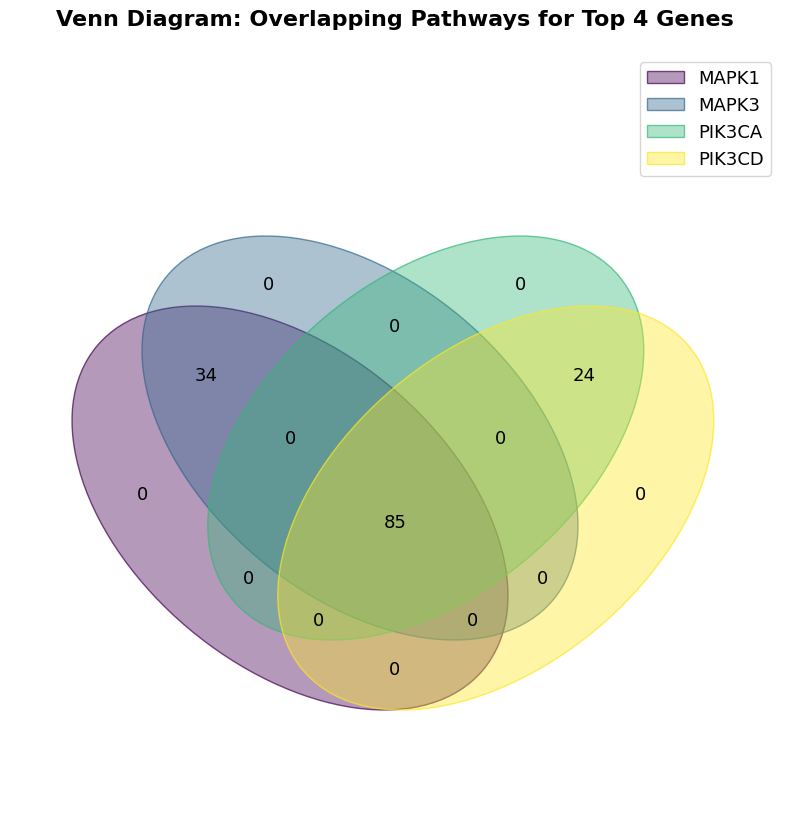

In [16]:
#use pyvenn to creat 4 sets venn plots
from venn import venn

fig, ax = plt.subplots(figsize=(12, 10))
venn_data = {gene: gene_to_pathways[gene] for gene in top_4_genes}
venn(venn_data, ax=ax)

#title
plt.title('Venn Diagram: Overlapping Pathways for Top 4 Genes', 
          fontsize=16, fontweight='bold', pad=20)

venn_file = f"{OUTDIR}/venn_diagram_top4_genes.png"
plt.savefig(venn_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

It's time to explore some new features!!

a. top 3 pathways with the highest number of genes

In [17]:
import pandas as pd

In [21]:
#read the csv file
df_map = pd.read_csv(f"{OUTDIR}/step1_gene_pathway_map.csv")
print(df_map.shape)
df_map.head()

(39858, 4)


,GENE_ID,GENE_SYMBOL,PATHWAY_ID,PATHWAY_NAME
0,hsa:84532,ACSS1,hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...
1,hsa:55902,ACSS2,hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...
2,hsa:124,ADH1A,hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...
3,hsa:125,ADH1B,hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...
4,hsa:126,ADH1C,hsa00010,Glycolysis / Gluconeogenesis - Homo sapiens (h...


In [23]:
#count unique genes per pathway
pathway_counts = df_map.groupby(['PATHWAY_ID', 'PATHWAY_NAME'])['GENE_SYMBOL'].nunique().reset_index()
pathway_counts.columns = ['PATHWAY_ID', 'PATHWAY_NAME', 'NUMBER_OF_GENES']

#sort by gene count in descending order
pathway_counts = pathway_counts.sort_values('NUMBER_OF_GENES', ascending=False).reset_index(drop=True)
pathway_counts.head(3)

,PATHWAY_ID,PATHWAY_NAME,NUMBER_OF_GENES
0,hsa01100,Metabolic pathways - Homo sapiens (human),1579
1,hsa05200,Pathways in cancer - Homo sapiens (human),533
2,hsa05022,Pathways of neurodegeneration - multiple disea...,481


In [ ]:
output_path = f"{OUTDIR}/pathway_gene_counts.csv" # output file path
pathway_counts.to_csv(output_path, index=False) #save to csv
print(f"Pathway gene counts saved to: {output_path}")

Pathway gene counts saved to: /Users/thandi/bioinfo575_final/output/pathway_gene_counts.csv


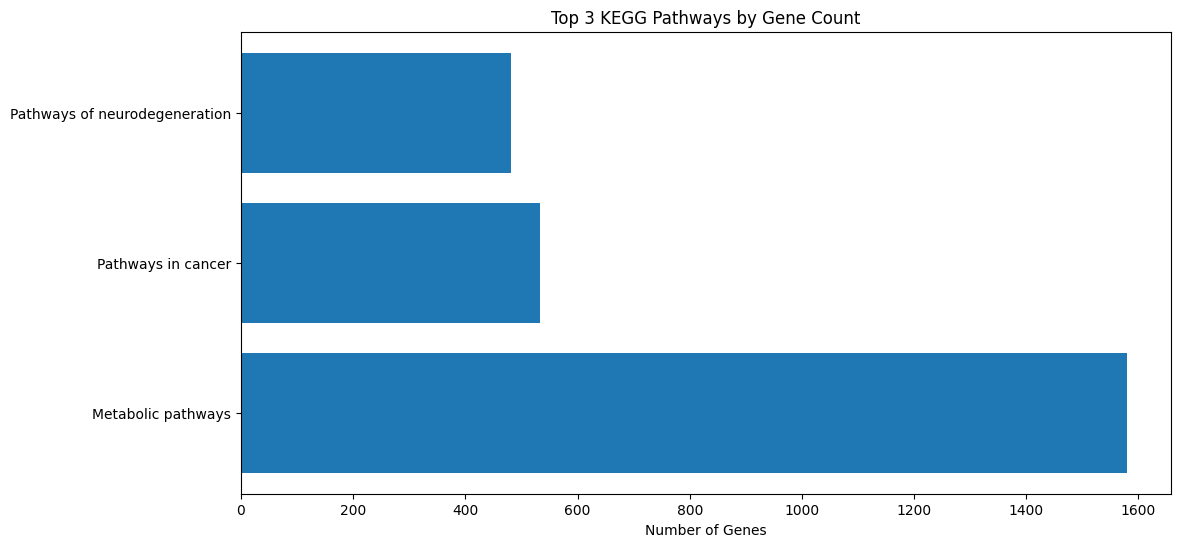

In [ ]:
import matplotlib.pyplot as plt

top3 = pathway_counts.head(3) #get top 3 pathways

plt.figure(figsize=(12, 6))
plt.barh(range(len(top3)), top3['NUMBER_OF_GENES'])
plt.yticks(
    range(len(top3)),
    [name.split(' - ')[0] if ' - ' in name else name
     for name in top3['PATHWAY_NAME']]
)
plt.xlabel('Number of Genes')
plt.title('Top 3 KEGG Pathways by Gene Count')

plt.savefig(f"{OUTDIR}/top3_pathways.png", dpi=300, bbox_inches="tight") #save figure
plt.show() #show figure
plt.close() #clear figure


The number of genes in the top 3 pathways varies a lot. For example, the metabolic pathway is the most comprehensive one, which contains nearly 3 times more genes than the pathways in cancer. This leads us to ask whether pathways overlap because they are related or because the same genes are used repeatedly/shared across multiple pathways.

To answer this question, we need to figure our if we should use the Fisher's Exact Test or Chi-square Test.

"Fisher's exact test is more accurate than the chi-square test or G–test of independence when the expected numbers are small. I recommend you use Fisher's exact test when the total sample size is less than , and use the chi-square or G–test for larger sample sizes. " https://stats.libretexts.org/Bookshelves/Applied_Statistics/Biological_Statistics_(McDonald)/02%3A_Tests_for_Nominal_Variables/2.07%3A_Fisher%27s_Exact_Test#:~:text=Fisher%27s%20exact%20test%20is%20more,means%20to%20be%20%22small%22. 

In [29]:
import numpy as np

# total number of unique genes in the analysis (gene universe)
gene_universe = df_map["GENE_SYMBOL"].nunique()

# number of genes per pathway
pathway_sizes = (
    df_map
    .groupby("PATHWAY_ID")["GENE_SYMBOL"]
    .nunique()
    .to_dict()
)


#AI was used here to help figure out how to calculate expected overlaps
import itertools as it

expected_overlaps = []

for p1, p2 in it.combinations(pathway_sizes.keys(), 2):
    size_A = pathway_sizes[p1]
    size_B = pathway_sizes[p2]

    # expected overlap under independence
    expected = (size_A * size_B) / gene_universe

    expected_overlaps.append(expected)

expected_overlaps = np.array(expected_overlaps)

print(f"Median expected overlap: {np.median(expected_overlaps):.2f}")
print(f"Minimum expected overlap: {np.min(expected_overlaps):.2f}")
print(f"Percentage of pathway pairs with expected overlap < 5: "
      f"{np.mean(expected_overlaps < 5) * 100:.1f}%")
print(f"Percentage of pathway pairs with expected overlap > 5: "
      f"{np.mean(expected_overlaps > 5) * 100:.1f}%")

Median expected overlap: 0.64
Minimum expected overlap: 0.00
Percentage of pathway pairs with expected overlap < 5: 96.7%
Percentage of pathway pairs with expected overlap > 5: 3.3%


Many pathway pairs have small expected overlap counts (<5), which violates chi-square assumptions; so using the Fisher’s exact test is the best choice.


In [31]:
from scipy.stats import fisher_exact

# gene universe
gene_universe = set(df_map["GENE_SYMBOL"])
N = len(gene_universe)

# genes per pathway
pathway_to_genes = (
    df_map
    .groupby("PATHWAY_ID")["GENE_SYMBOL"]
    .apply(set)
    .to_dict()
)

# pathway names (for output)
pid_to_name = (
    df_map
    .drop_duplicates("PATHWAY_ID")
    .set_index("PATHWAY_ID")["PATHWAY_NAME"]
    .to_dict()
)

In [ ]:
results = []

for p1, p2 in it.combinations(pathway_to_genes.keys(), 2):
    genes_A = pathway_to_genes[p1]
    genes_B = pathway_to_genes[p2]

    # observed counts
    overlap = len(genes_A & genes_B)
    A_only = len(genes_A - genes_B)
    B_only = len(genes_B - genes_A)
    neither = N - overlap - A_only - B_only

    # 2x2 table
    table = [
        [overlap, A_only],
        [B_only, neither]
    ]

    # Fisher's exact test (greater = enrichment of overlap)
    odds_ratio, p_value = fisher_exact(table, alternative="greater")

    results.append({
        "PATHWAY_ID1": p1,
        "PATHWAY_NAME1": pid_to_name[p1],
        "PATHWAY_ID2": p2,
        "PATHWAY_NAME2": pid_to_name[p2],
        "OVERLAP_GENES": overlap,
        "ODDS_RATIO": odds_ratio,
        "P_VALUE": p_value
    })

    


In [ ]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Convert results list to DataFrame
df_fisher = pd.DataFrame(results)


# Multiple testing correction (FDR)

df_fisher["FDR"] = multipletests(
    df_fisher["P_VALUE"],
    method="fdr_bh"
)[1]

# Sort by strongest evidence
# smallest FDR AND largest overlap
df_fisher = df_fisher.sort_values(
    ["FDR", "OVERLAP_GENES"],
    ascending=[True, False]
).reset_index(drop=True)

# Add -log10(FDR) so its easier to read
df_fisher["log10_FDR"] = -np.log10(
    df_fisher["FDR"].replace(0, np.nextafter(0, 1))
)

# Filter significant overlaps (FDR < 0.05)

significant_overlaps = df_fisher[df_fisher["FDR"] < 0.05]

#save
df_fisher.to_csv(
    f"{OUTDIR}/pathway_overlap_fisher_results.csv",
    index=False
)

# Inspect top results
significant_overlaps.head(10)



,PATHWAY_ID1,PATHWAY_NAME1,PATHWAY_ID2,PATHWAY_NAME2,OVERLAP_GENES,ODDS_RATIO,P_VALUE,FDR,log10_FDR
0,hsa05010,Alzheimer disease - Homo sapiens (human),hsa05022,Pathways of neurodegeneration - multiple disea...,337,366.253472,0.000000e+00,0.000000e+00,323.306215
1,hsa05014,Amyotrophic lateral sclerosis - Homo sapiens (...,hsa05022,Pathways of neurodegeneration - multiple disea...,298,186.212730,0.000000e+00,0.000000e+00,323.306215
2,hsa05016,Huntington disease - Homo sapiens (human),hsa05022,Pathways of neurodegeneration - multiple disea...,254,165.501802,2.959759e-293,6.698526e-289,288.174021
3,hsa05014,Amyotrophic lateral sclerosis - Homo sapiens (...,hsa05016,Huntington disease - Homo sapiens (human),227,160.249055,2.174584e-274,3.691139e-270,269.432840
4,hsa05012,Parkinson disease - Homo sapiens (human),hsa05022,Pathways of neurodegeneration - multiple disea...,231,198.222316,1.048268e-272,1.423464e-268,267.846653
5,hsa05010,Alzheimer disease - Homo sapiens (human),hsa05020,Prion disease - Homo sapiens (human),218,180.765477,5.370694e-267,6.077477e-263,262.216277
6,hsa05010,Alzheimer disease - Homo sapiens (human),hsa05012,Parkinson disease - Homo sapiens (human),211,168.080589,5.924032e-256,5.745972e-252,251.240636
7,hsa05012,Parkinson disease - Homo sapiens (human),hsa05020,Prion disease - Homo sapiens (human),189,225.795259,1.567334e-251,1.330196e-247,246.876084
8,hsa05020,Prion disease - Homo sapiens (human),hsa05022,Pathways of neurodegeneration - multiple disea...,223,132.700819,9.253254e-250,6.980655e-246,245.156104
9,hsa05016,Huntington disease - Homo sapiens (human),hsa05020,Prion disease - Homo sapiens (human),187,142.480291,6.600522e-229,4.481491e-225,224.348578


The strongest pathway overlaps were seen in neurodegenerative disease pathways. This suggests that these conditions share core mechanisms and likely have biological processes that depend on one another.
